## Supervised Learning Final Project: Modelling Insurance Costs

Github Public Repo Link: https://github.com/unit4216/boulder-super-learning/tree/main

**The problem**: A fictional insurance company, Mass Insurance, needs a way to calculate what they should charge their clients based on client-specific factors (e.g. is the client a smoker?)

**The solution**: We will train and refine a multivariate OLS (ordinary least squares) regression model for this exact purpose, such that Mass Insurance can input determining factors into the model and the model will return the amount that they should charge their new client.

### The data
Our data is a public dataset that was sourced from Kaggle (see citation below) and downloaded as a CSV. It consists of over a thousand records that represent insured individuals, including what their (presumably annual) insurance charges are and as well as various health factors, such as if the individual is a smoker, their age, etc.

*APA Citation*: Jain, Simran. (2020). Insurance Premium Data. [Data set]. Kaggle. https://www.kaggle.com/datasets/simranjain17/insurance

 <u>**Data breakdown**</u> 
 
 **Number of records**: 1338
 
 **Number of columns**: 7
 
 **Dependent variable**
- **Charges**: *float* - The amount that the insured pays for insurance (presumably annual)
        
 **Independent variables**
- **Age**: *integer* - The age of the insured
- **Sex**: *category (male, female)* - The sex of the insured
- **BMI**: *integer* - The BMI (body mass index) of the insured
- **Children**: *integer* - The number of children of the insured
- **Smoker**: *category (yes, no)* - Whether the insured is a smoker
- **Region**: *category (southwest, southeast, northwest, northeast)* - The region where the insured lives
        

In [1257]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import sklearn.model_selection
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('insurance.csv')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 73.4+ KB
None


**Data Cleaning Pt 1**

The first thing we notice in analyzing our data is that there appears to be 1339 entries, but each column has 1338 non-null entries - meaning that we have an empty row, probably at the end of the CSV.  Let's go ahead and drop that row, and any rows with NaN values.

In [1258]:
# drop rows where any value is NaN
data = data.dropna(how='any')
# validate our cleaning
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 83.6+ KB
None


**Data Cleaning Pt 2**

Let's check our data for any outliers, valid or invalid, that might skew our results.  We can do this by plotting a histogram for each of our numerical features.

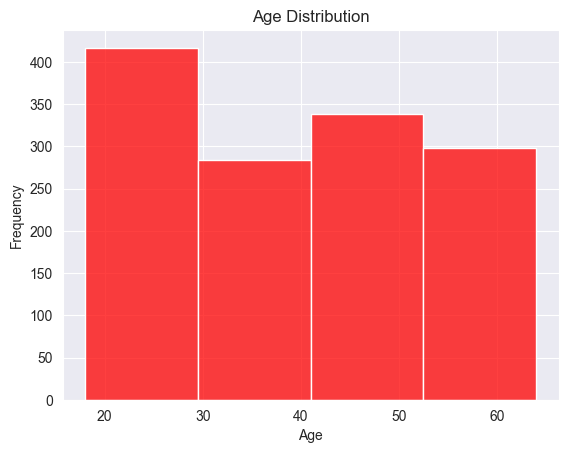

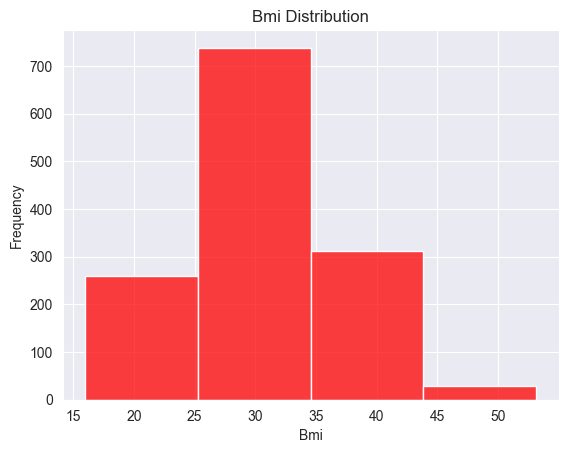

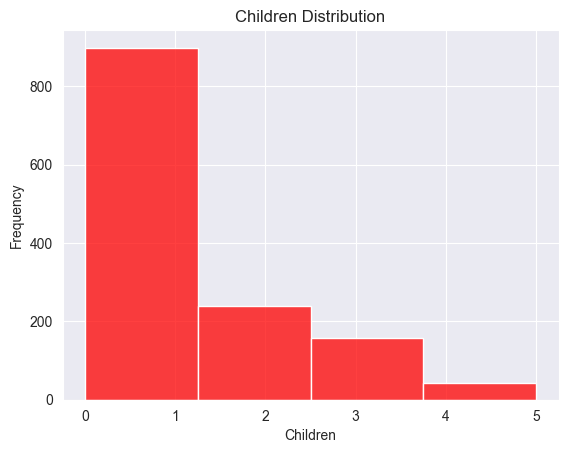

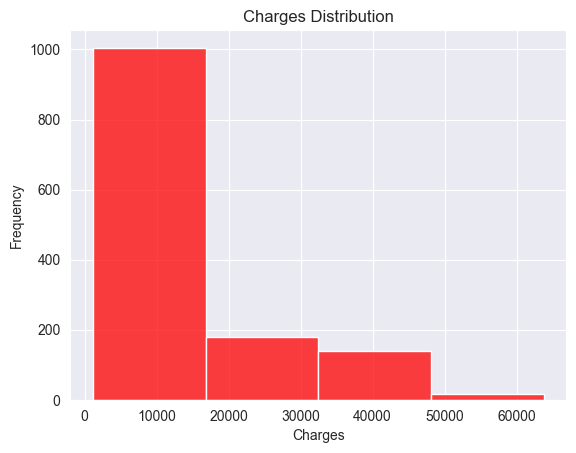

In [1259]:
features = ['age', 'bmi', 'children', 'charges']

# iterate over our numerical features and plot a histogram to easily detect outliers
for feature in features:
    sns.histplot(data[feature], bins=4, kde=False, color='red')
    plt.title(f'{feature.capitalize()} Distribution')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.show()


**Data Cleaning Conclusions**

Really, this dataset is already very clean - we just needed to drop the empty row and, as we will see later in the *Feature Engineering* section, perform some encoding on our categorical features.

**EDA Pt 1**

Let's go ahead and generate a correlation matrix and heatmap for our currently available numerical features.

As we can see from the heatmap, we don't really have any features with strong correlations to `charges` at this point.

Axes(0.125,0.11;0.62x0.77)


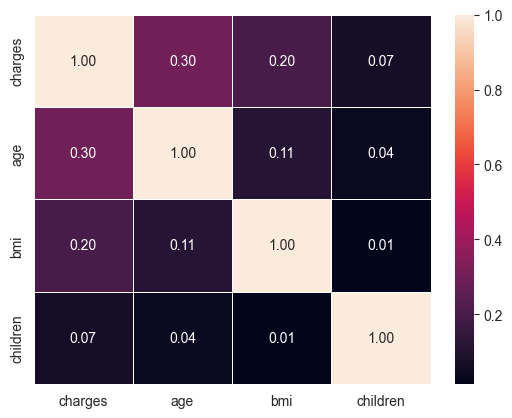

In [1260]:
# move `charges` to first column position - this is needed for correlation matrix to parse it as the dependent variable
cols = ['charges'] + [col for col in data if col != 'charges']
data = data[cols]

# remove all categorical features - we will add these in later, once they have been engineered
prelim_eda_data = data.select_dtypes(include=['int64', 'float64'])

# generate correlation matrix and heatmap
corr = prelim_eda_data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: Feature Engineering Pt 1**
 
As you saw from the previous heatmap, it doesn't seem like we have a lot to work with when we omit our categorical features.

As such, let's go ahead and try and encode some of these categorical features such that we can potentially use them in our model.

The first, and easiest to encode, is the `smoker` feature, which describes whether the insured is a smoker.  This has a value of `yes` or `no`, which we will convert to binary (`0` or `1`).

In [1261]:
# encode smoker to binary
smoker_map = {'yes': 1, 'no': 0}
data['smoker'] = data['smoker'].apply(lambda x: smoker_map[x])

**Models: Feature Engineering Pt 2**

Next, we have a couple of categorical features (`sex` and `region`) which are slightly harder to encode as they are not ordinal categorical variables and
thus cannot be encoded into integers.

For these features, we will need to use one-hot encoding, which basically unzips each feature into multiple columns, where each column represents a category of the feature and is assigned a binary value.  Ex. `sex` can be `male` or `female`.  One-hot encoding would create the columns `sex_male` and `sex_female` and, in a given row where `sex` = `male`, `sex_male` would be assigned the value of `1` while `sex_female` would be 0.

We can easily one-hot encode both of these features using the pandas `get_dummies` method.


In [1262]:
# one-hot encoding for categorical variables.  get_dummies also removes the original columns, which makes things even easier for us.
data = pd.get_dummies(data, columns=['sex', 'region'], dtype='int')

# validate that all features are now numeric
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   charges           1338 non-null   float64
 1   age               1338 non-null   float64
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   float64
 4   smoker            1338 non-null   int64  
 5   sex_female        1338 non-null   int64  
 6   sex_male          1338 non-null   int64  
 7   region_northeast  1338 non-null   int64  
 8   region_northwest  1338 non-null   int64  
 9   region_southeast  1338 non-null   int64  
 10  region_southwest  1338 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 125.4 KB
None


**EDA Pt 2**

Now that our categorical features are encoded, we can perform another round of EDA with all features now available.

Based on the heatmap below, we will probably want to focus on the `smoker`, `age`, and `bmi` features, as these are the features most highly correlated with `charges`.

Axes(0.125,0.11;0.62x0.77)


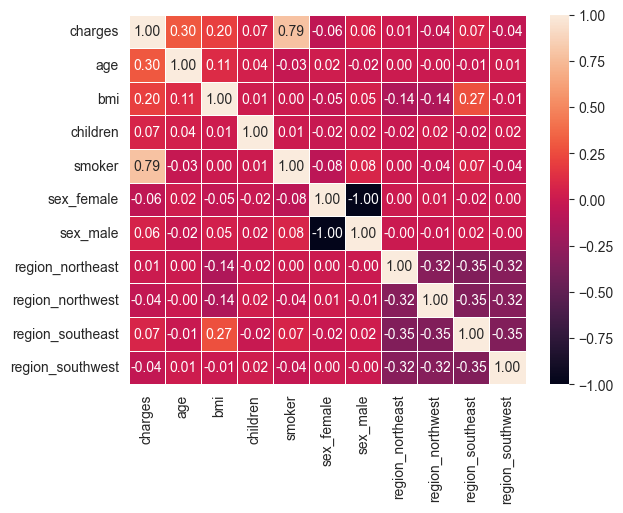

In [1263]:
corr = data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: Feature Engineering Pt 3**

Given our EDA findings, we can now select our features.
 
We are going to drop all features except for `smoker`, `age`, and `bmi` since these were the features with the highest correlation with `charges`.

In [1264]:
data = data[['charges', 'smoker', 'age', 'bmi']]

**Models: Multi-Linear Regression/Collinearity**

Now that we have selected our features, we can see that these features do not display collinearity or even high correlation as each feature's correlation with each other is quite low.

This is easy to see when reviewing a heatmap of only our selected features - the highest correlation between features is only `0.11` between `age` and `bmi`, which is negligible.


Axes(0.125,0.11;0.62x0.77)


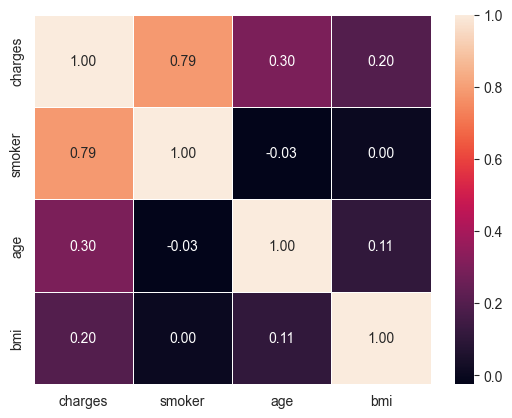

In [1265]:
corr = data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: Multiple ML Models Pt 1**

For our problem, a regression model seems most appropriate, since we are trying to determine what to charge the insured and not whether they should be covered, or some other binary classification.

Let's start by generating some uni- and multi-variate OLS regression models, using the features we selected earlier.

Similar to how we approached this problem in class, we will start with a uni-variate model and add features in order of descending correlation (i.e. add more correlated/important features first).

As we can see from the model summaries, the models improve significantly in r-squared value as we add more features, with the final three-feature multi-variate model having the highest r-squared value. 

In [1266]:
# split our data into testing and training data
X_train, X_test = sklearn.model_selection.train_test_split(data, test_size=0.2, random_state=42)

# these are the features we selected, in order of descending correlation with `charges`
useful_features = ['smoker','age','bmi']

models = []

formula = 'charges~'

# iterate over features, appending them to the formula and thus to each new model
for feature in useful_features:
    formula = f'{formula}+{feature}'
    model = smf.ols(formula=formula, data=X_train).fit()
    models.append(model)
    
for model in models:
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1660.
Date:                Fri, 24 May 2024   Prob (F-statistic):          1.04e-219
Time:                        10:24:51   Log-Likelihood:                -11068.
No. Observations:                1070   AIC:                         2.214e+04
Df Residuals:                    1068   BIC:                         2.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8578.3225    258.076     33.240      0.0

**Models - Multiple ML Models Pt 2**

Now that we've gotten a cursory look at our simple uni- and multi-variate models, let's try adding some polynomials to increase the fit.

Since the final multi-variate model we generated (with three features) has the highest r-squared value, let's start from that model, adding polynomial features much the same way we did in class.

Here, we iterate over an integer range and generate an array of polynomial models with increasing degrees.

As we can see, our multi-variate polynomial models generally achieve higher r-squared results than our single-degree multi-variate model. But will this advantage hold up when we run the model on our test dataset?

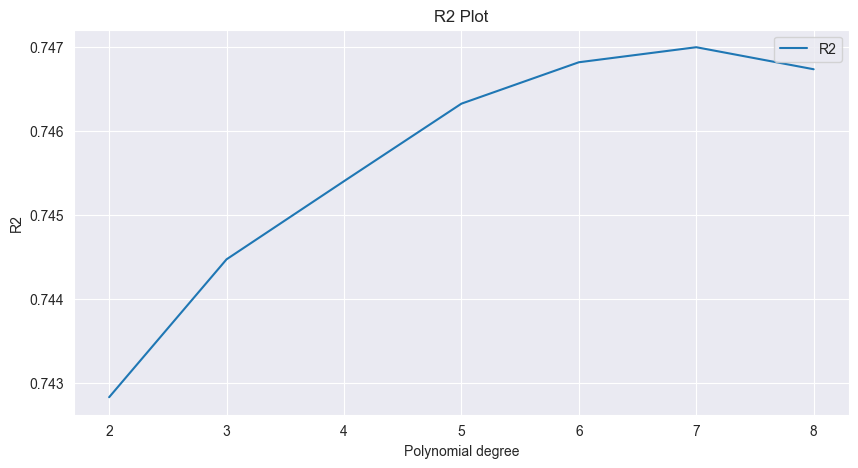

In [1267]:
poly_models = []

# base formula of our best multi-variate model
formula = 'charges~smoker+age+bmi'

degrees = range(2, 9)

# iterate over polynomial degrees in order to add polynomial features to each model
for i in degrees:
    formula = f'{formula}+np.power(smoker,{i})+np.power(age,{i})+np.power(bmi,{i})'
    poly_model = smf.ols(formula=formula, data=X_train).fit()
    poly_models.append(poly_model)
    
# get the r-squared value of each polynomial model that we generated    
r2s = [model.rsquared for model in poly_models]

# plot these r-squared values
data = pd.Series(r2s)
df = pd.DataFrame({'degrees': degrees, 'R2': data})
df.plot(x='degrees', y='R2', figsize=(10, 5), title='R2 Plot', legend=True, grid=True, label='R2')
plt.xlabel('Polynomial degree')
plt.ylabel('R2')
plt.show()


**Results and Analysis Pt 1**

Here, we're going to go ahead and run our best multi-variate single-degree model on our test data and evaluate the results.

We're going to get both the RMSE (root mean squared error) and MAE (mean absolute error) values for this model as they are easy to compare, and both could be considered useful when evaluating a model to calculate premiums.

*In the case of insurance charges, it's hard to say whether MAE or RMSE is a better metric without having more domain knowledge about the insurance industry.  I would hazard a guess that RMSE might be better since large errors are penalized more harshly, and we want to avoid a situation where a potential client is scared off due to way-too-high premiums.  But I really couldn't say definitively.*

As you'll see below, our model does an OK job of predicting premiums.  The error rate does seem fairly high given that the average charge is only about $13,000, and looking at our plot of actual vs predicted results, there would probably be some room for improvement were we to further refine this model.

RMSE: 5874.763304187508
MAE: 4260.56009109952
8487.8803
Mean charges: 12968.31706286941


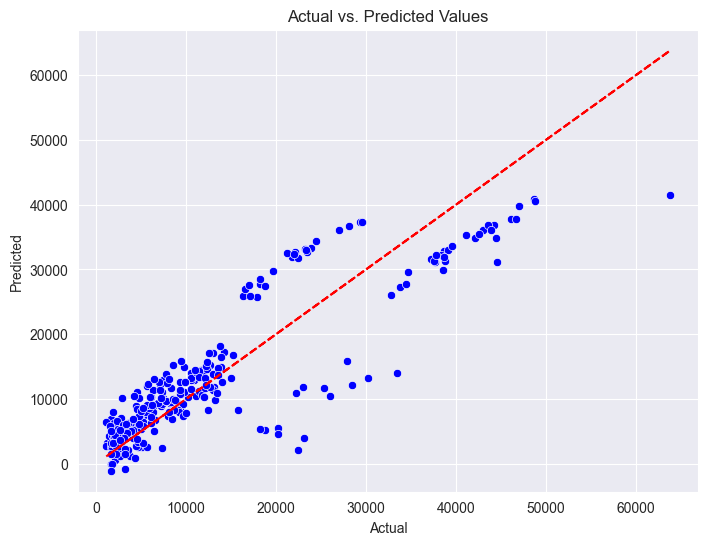

In [1271]:
from sklearn.metrics import root_mean_squared_error

# this was our three-feature model which had the highest r-squared value out of our single-degree models
best_multivariate_model = models[-1]

y_pred = best_multivariate_model.predict(X_test)
y_test = X_test['charges']

# calculate RMSE and MAE for our single-degree model
first_degree_rmse = root_mean_squared_error(y_test, y_pred)
first_degree_mae = mean_absolute_error(y_test, y_pred)
# get the mean charges to give a sense of scope of errors
mean_charges = sum(y_test) / len(y_test)

print(f'RMSE: {first_degree_rmse}')
print(f'MAE: {first_degree_mae}')
print(f'Mean charges: {mean_charges}')

# plot our actual vs predicated values
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, marker='o', color='blue')
plt.plot(data['Actual'], data['Actual'], 'r--')  
plt.title('Actual vs. Predicted Values')
plt.show()


**Results and Analysis Pt 2**

Next, we'll evaluate our test results from our polynomial models, which generally had higher r-squared values than our best single-degree multivariate model.

We'll iterate over each polynomial model to get its MAE and RMSE, and then plot the results compared to our single-degree model.

As you can see, despite our polynomial models having better r-squared values than our single-degree model, our single-degree model has a lower error rate (both RMSE and MAE) than our polynomial models.  Presumably, our polynomial models were overfit to the training data, and thus did not produce better results.

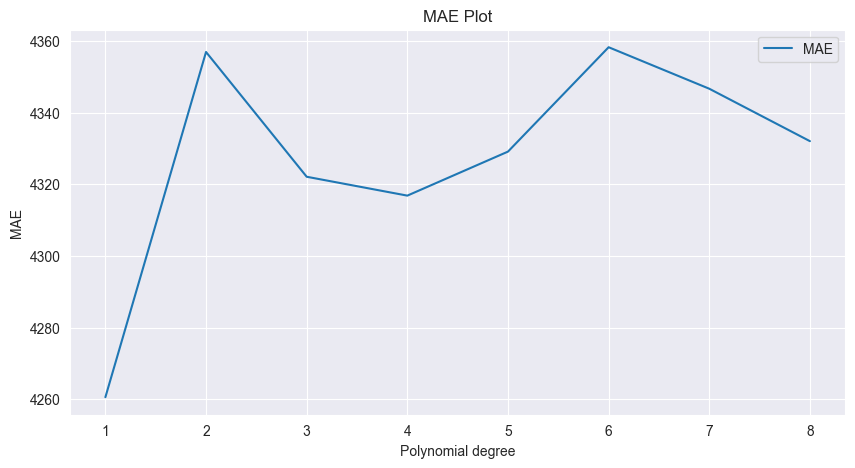

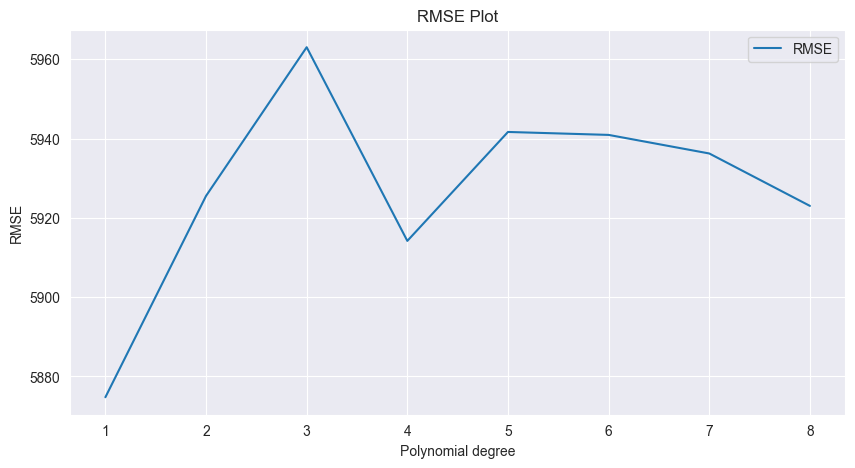

In [1269]:
# we include our single-degree MAE and RMSE values since we are going to compare them to our polynomials
mae_values = [first_degree_mae]
rmse_values = [first_degree_rmse]

# iterate over our polynomial models to generate our RMSE and MAE values for each model
for poly in poly_models:

    y_pred = poly.predict(X_test)
    y_test = X_test['charges']
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    mae_values.append(mae)
    rmse_values.append(rmse)
    
# add the first degree to our list of degrees, since we will be plotting our single-degree results
degrees = [1] + list(degrees)
    
# plot MAE values
df = pd.DataFrame({'degree': degrees, 'MAE': mae_values})
df.plot(x='degree', y='MAE', figsize=(10, 5), title='MAE Plot', legend=True, grid=True, label='MAE')
plt.xlabel('Polynomial degree')
plt.ylabel('MAE')
plt.show()

# plot RMSE values
df = pd.DataFrame({'degree': degrees, 'RMSE': rmse_values})
df.plot(x='degree', y='RMSE', figsize=(10, 5), title='RMSE Plot', legend=True, grid=True, label='RMSE')
plt.xlabel('Polynomial degree')
plt.ylabel('RMSE')
plt.show()


**Demonstration**

Let's take a step back and remember our fictional insurance, Mass Insurance.  Let's say they want to get a premium value for a new client - he's 31, a smoker, and has a BMI of 25.

We can plug those values into the model and have it return us a premium amount (see below).  This demonstrates the practical application of our model.

In [1270]:

new_client = {"age": 31, "smoker": 1, "bmi": 25}

y_pred = best_multivariate_model.predict(new_client)

new_client_charge = y_pred[0]

print(new_client_charge)

28170.54165921081


**Conclusions**

*Learning and Takeaways:*

Our three-feature, single-degree model turned out to be the best model we created.  Despite its lower r-squared value, it outperformed our polynomial models.  My main takeaway from this is that we want to avoid over-fitting models and also not focus too much on the r-squared value that the model achieves on its training data.

I also found it interesting that a binary feature, `smoker`, had the most correlation with `charges`.  Of course it makes sense - being a smoker is highly detrimental to health and premiums are typically higher for smokers, but it's not the feature that I expected to have the highest correlation.

*Something that Didn't Work:*

Our polynomial models were a slight failure.  They had higher r-squared values on the training data, but ended up also having higher error rates when they were applied to the test data.  Presumably, this occurred because we overfit our polynomial models which led to this outcome.

*Ways to Improve:*

Maybe some more experimenting with different combinations of our selected features and polynomial degrees would have been useful.  I also think that it may have been premature to discard some features based on weak correlation - presumably there is a way these could potentially be incorporated to produce results, or at least we could have tested them further.  More domain knowledge of the insurance industry definitely would have helped in creating a better model.